<center><b><font size=6>Unsupervised Data Analysis <b><center>


This section involves further preprocessing the dataset by analyzing feature distributions, reducing dimensionality using PCA, and applying K-means and Hierarchial clustering to identify object labels. Additionally, anomaly detection is performed to enhance cluster quality by removing outliers. 

Here we perform 3 different tasks:

1) Dimentionality Reduction

2) Unsupervised Clustering Algorithms

3) Anomaly Detection

   

In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# Dimensionality Reduction
This part consists of the subsections below:

1) Feature Selection: Select features with minimum overlapping distribution

2) Correlation Analysis: drop the highly correlated features for further analysis

3) PCA: Apply PCA to further reduce the dimensionality of the dataset while retaining most of the variability. Reduce to 2 components. 

In [2]:
#First define the category you want to analyze you can choose 'browser', 'website', 'query'
category = 'browser'

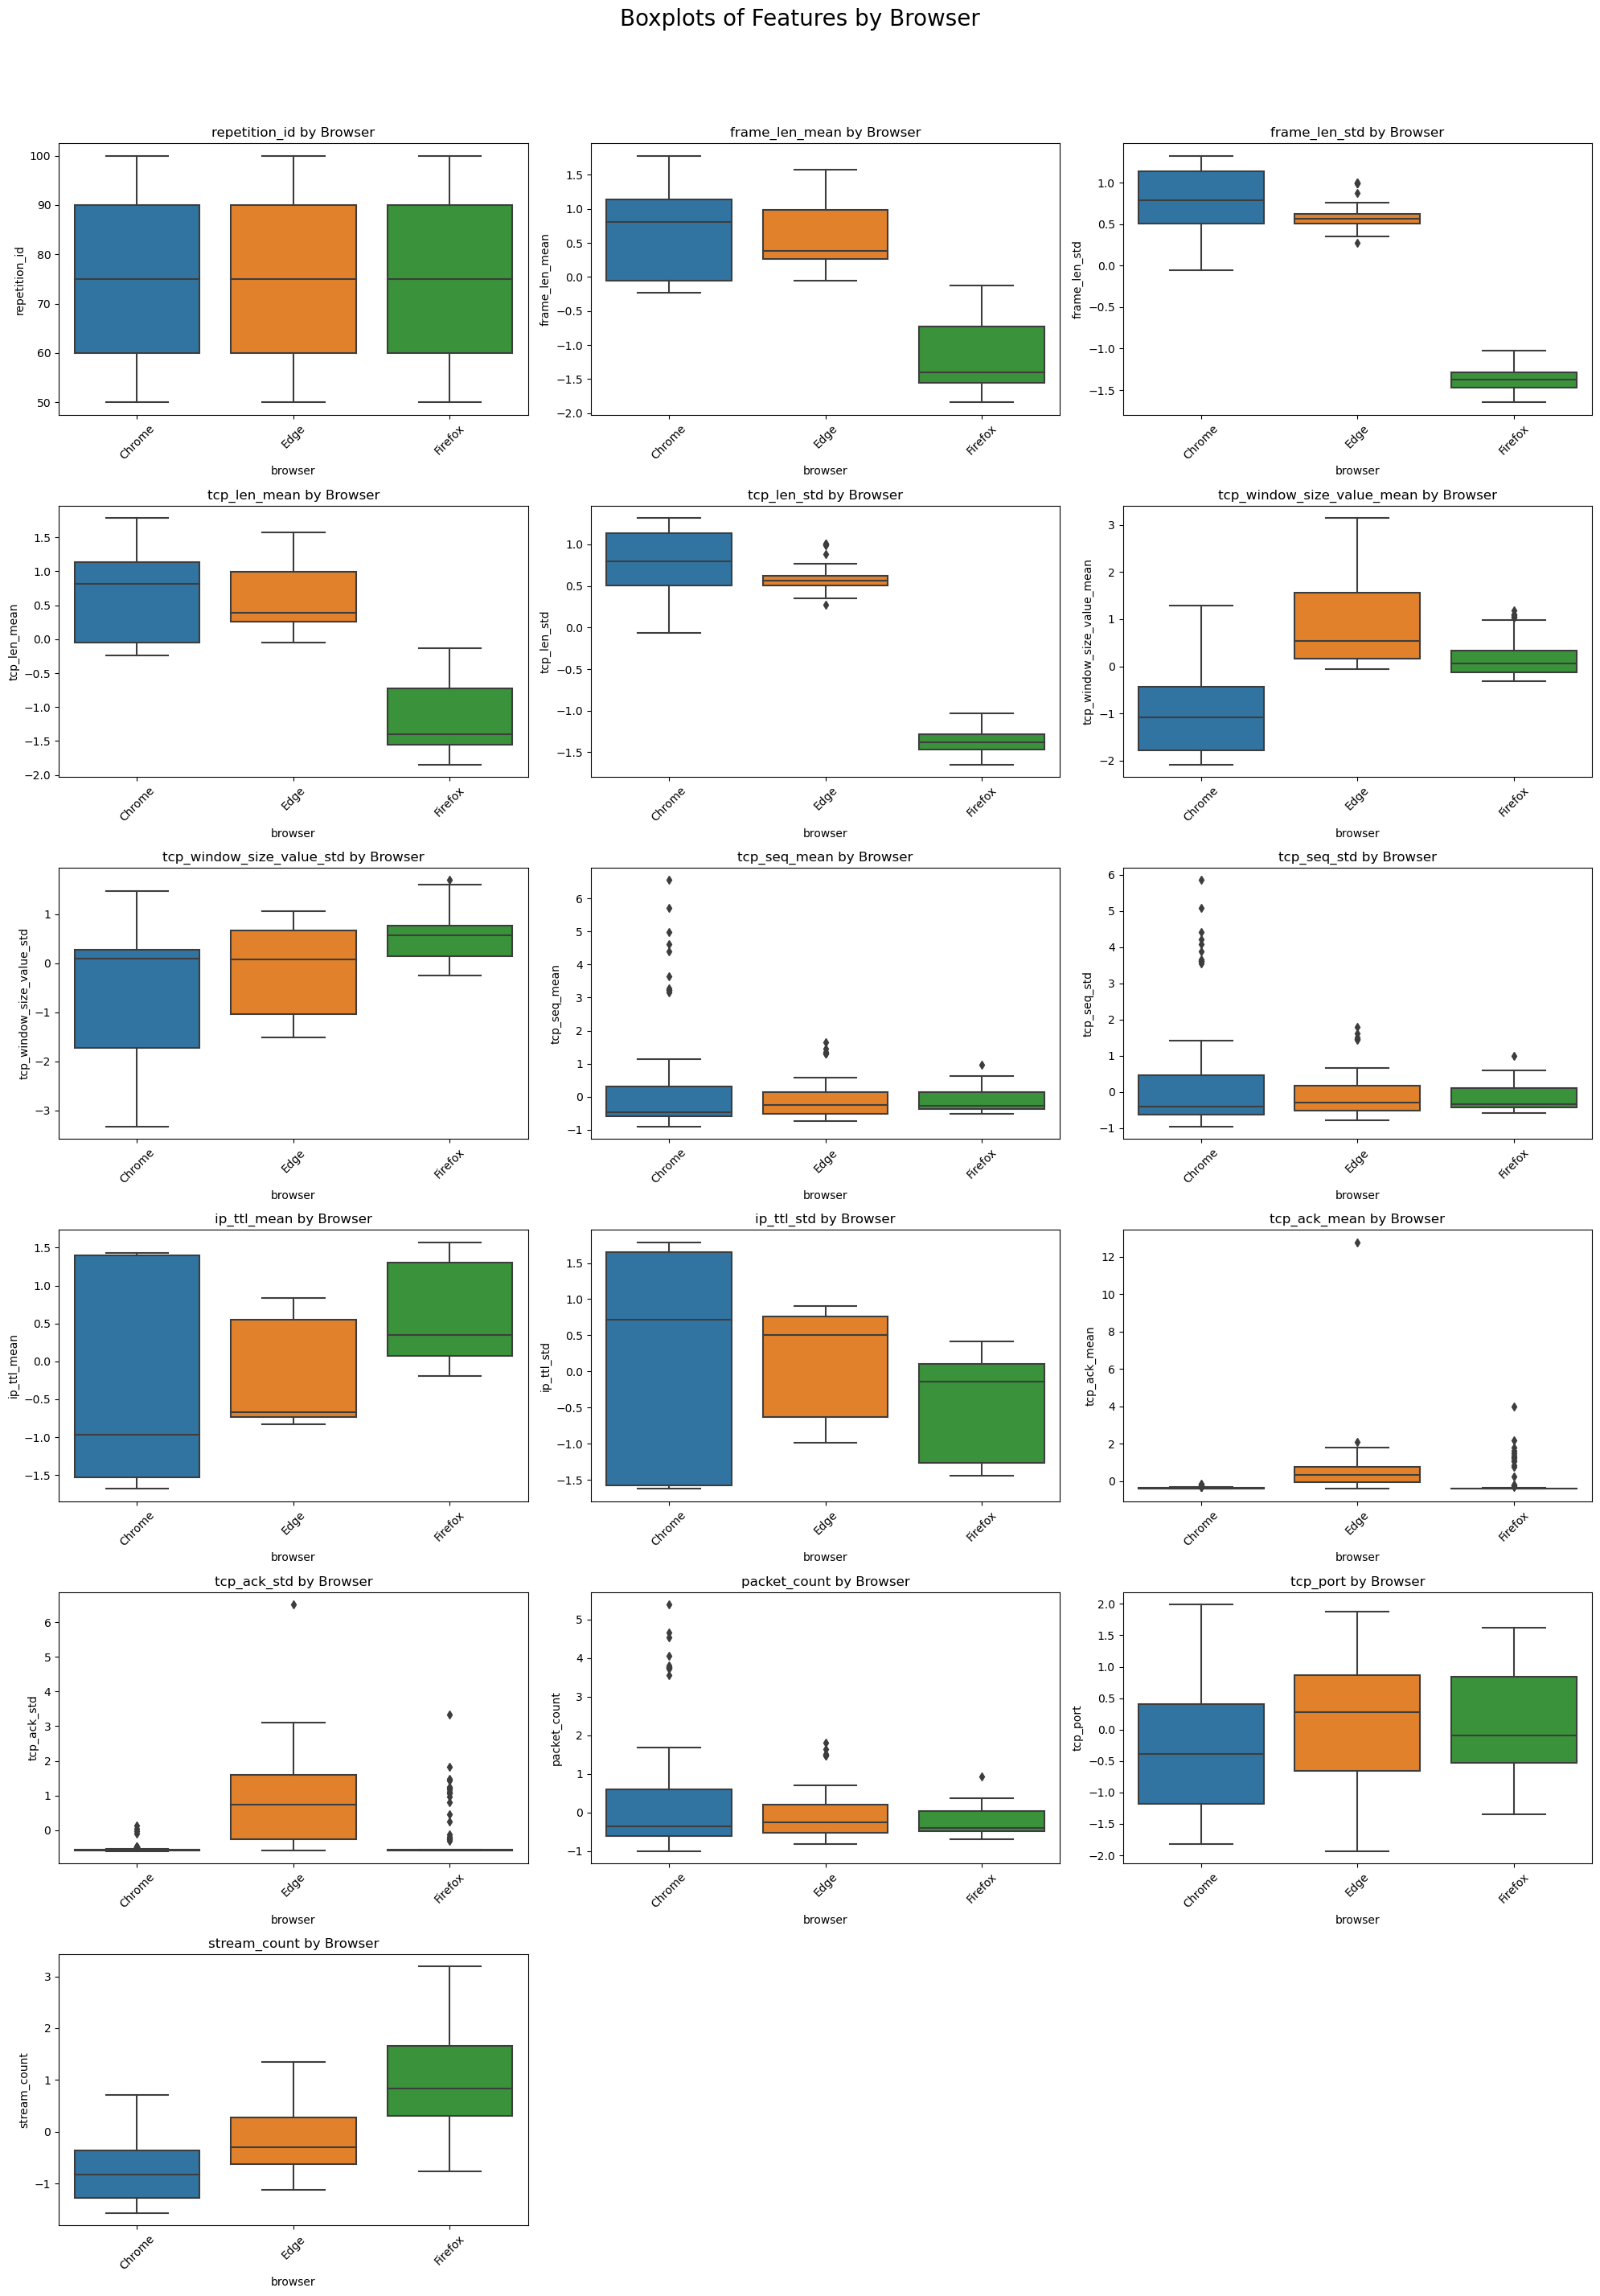

In [3]:
#--------------------------------------------------(Feature Selection based on the category)---------------------------------------------------------#

def plot_feature_boxplots(category_name, df):
    """
    Plots boxplots of each numerical feature against the given categorical variable in the dataframe.

    Parameters:
    - category_name: str, the name of the categorical column to plot against.
    - df: DataFrame, the data to plot.

    Returns:
    - None, displays the boxplots.
    """
    # Get the number of numerical features
    num_features = len(df.select_dtypes(include=['float64', 'int64']).columns)
    
    # Determine the number of rows and columns based on the number of features
    num_cols = 3
    num_rows = (num_features // num_cols) + int(num_features % num_cols > 0)
    
    # Set up the plotting environment
    plt.figure(figsize=(20, num_rows * 5))
    plt.suptitle(f'Boxplots of Features by {category_name.capitalize()}', fontsize=20)

    # Plot each numerical feature against the specified category
    for i, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=category_name, y=col, data=df)
        plt.title(f'{col} by {category_name.capitalize()}')
        plt.xticks(rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig('boxplots.png')
    plt.show()




# Load the main dataset
df_standard = pd.read_csv('../1_DataAcqusition_PreProcessing/df_standard.csv')

#Visualize the boxplots
plot_feature_boxplots(category, df_standard)



In the next section we can determine and select the features that have minimum overlap of interquartile ranges.

In [4]:
#These threshold values have been discovered experimentally, you can change it according to your preference

if category == 'browser':
    t = 0.2
elif category == 'website': 
    t = 0.3

def select_best_features(category_name, df, threshold=t):
    """
    Automatically selects the best features for clustering based on the overlap of interquartile ranges (IQR)
    between different categories.

    Parameters:
    - category_name: str, the name of the categorical column to use for comparison.
    - df: DataFrame, the data to analyze.
    - threshold: float, the maximum allowed overlap between IQRs for a feature to be considered useful.

    Returns:
    - selected_features: list, the names of the best features for clustering.
    """
    selected_features = []
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

    for feature in numerical_features:
        iqr_overlap = 0
        
        # Get the unique categories
        categories = df[category_name].unique()
        
        # Calculate the IQR for each category
        iqr_dict = {}
        for category in categories:
            category_data = df[df[category_name] == category][feature]
            q1 = category_data.quantile(0.25)
            q3 = category_data.quantile(0.75)
            iqr_dict[category] = (q1, q3)
        
        # Calculate the overlap between IQRs
        for cat1 in categories:
            for cat2 in categories:
                if cat1 != cat2:
                    overlap = max(0, min(iqr_dict[cat1][1], iqr_dict[cat2][1]) - max(iqr_dict[cat1][0], iqr_dict[cat2][0]))
                    iqr_overlap += overlap / (iqr_dict[cat1][1] - iqr_dict[cat1][0])
        
        # Average the overlap and check if it's below the threshold
        iqr_overlap /= len(categories) * (len(categories) - 1)
        
        if iqr_overlap < threshold:
            selected_features.append(feature)
    
    return selected_features


best_features = select_best_features(category, df_standard)

if best_features == []:
    print("Try increasing the threshold!")
    
#Print the selected features for browser
best_features

['frame_len_std', 'tcp_len_std', 'tcp_window_size_value_mean', 'stream_count']

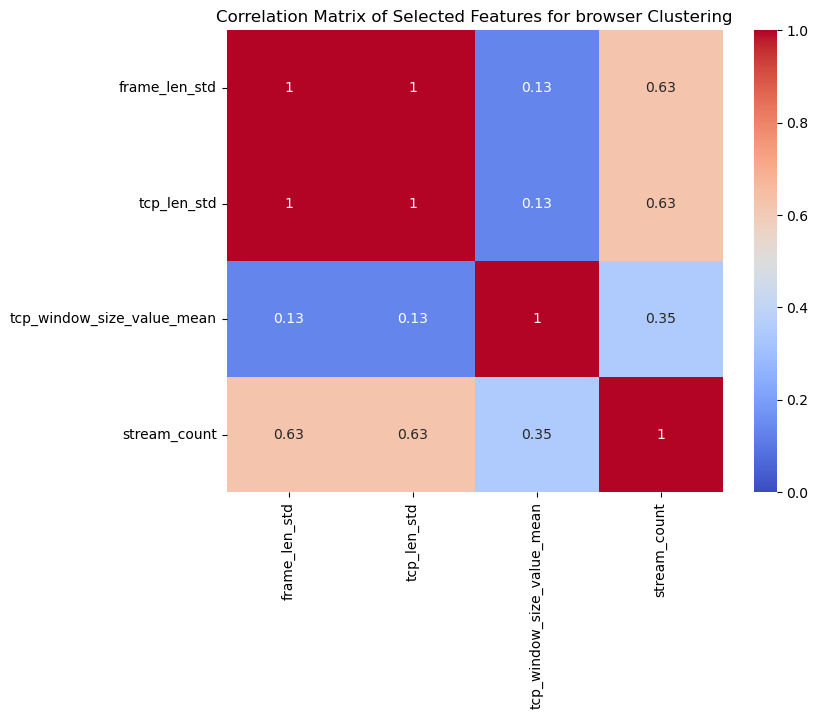

Features to discard: ['frame_len_std']


In [5]:
#-------------------------------------------------(Correlation Analysis for Selected Features)-------------------------------------------------------#


# Calculate the correlation matrix for the selected features
corr_matrix = df_standard[best_features].corr().abs()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title(f'Correlation Matrix of Selected Features for {category} Clustering')
#plt.savefig('heatmap.png', bbox_inches='tight')
plt.show()


def corr_analysis(df, selected_features, threshold=0.8):
    """
    Identifies features to discard based on the correlation matrix and a specified threshold.
    
    Parameters:
    - df: pandas.DataFrame, the dataframe containing the data.
    - selected_features: list of str, the selected features to analyze.
    - threshold: float, the correlation threshold above which features are considered highly correlated.
    
    Returns:
    - features_to_discard: list of str, features that should be discarded.
    - df_remaining: pandas.DataFrame, the dataframe with the remaining features after discarding.
    """
    # Calculate the correlation matrix for the selected features
    correlation_matrix = df[selected_features].corr()

    # Initialize set to keep track of features to discard
    features_to_discard = set()

    # Iterate through the correlation matrix
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                # Check which feature has more correlations and mark it for removal
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                if (col1 not in features_to_discard) and (col2 not in features_to_discard):
                    if correlation_matrix[col1].abs().sum() > correlation_matrix[col2].abs().sum():
                        features_to_discard.add(col1)
                    else:
                        features_to_discard.add(col2)

    # Convert set to list
    features_to_discard = list(features_to_discard)
    print(f"Features to discard: {features_to_discard}")
    
    # Create a new dataframe with the remaining features
    df_remaining = df[selected_features].drop(columns=features_to_discard)
    df_remaining['browser'] = df['browser']
    df_remaining['website'] = df['website']
    df_remaining['query'] = df['query']
    
    return features_to_discard, df_remaining

#Here we discard the correlated features and save the remaining features with their 'browser', 'website', 'query' labels within a new dataframe
features_to_discard, df_remaining = corr_analysis(df_standard, best_features, threshold=0.8)


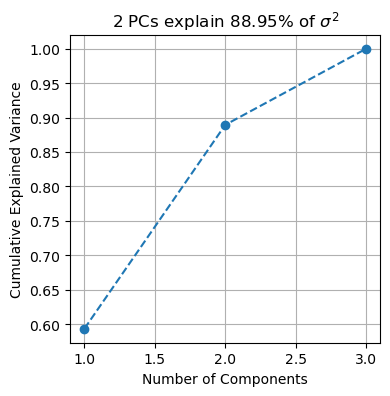

With 2 components we save 88.94755926323019% of the variance. We are good to go with PCA!


In [6]:
#----------------------------------------------------(PCA Analysis) -------------------------------------------------------#

# Copy the df with selected features after correlation analysis into data
data = df_remaining.copy()
#Extract the numerical columns
num_cols = [col for col in data.columns if col not in ['browser','website', 'query', 'repetition_id']]

# Select only the numerical features for PCA and define the number of clusters
numerical_features = num_cols
df_numerical = data[numerical_features]

def pca_analysis(df_numeric,i=2):
    """
    Perform PCA analysis on the given dataframe and plot the cumulative explained variance.

    Parameters:
    df (pd.DataFrame): The input dataframe.

    Returns:
    None
    """    
    features_new = df_numeric
    
    # Drop rows with NaN or infinite values
    features_new = features_new.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Perform PCA
    pca = PCA(random_state=15)
    pca.fit(features_new)
    pca_result = pca.transform(features_new)
    
    # Describe how much of the dataset variability is indicated by a given amount of features
    explained_variance_ratio = pca.explained_variance_ratio_

    # Print explained variance ratio
    #print("Explained variance ratio for each component:")
    #print(explained_variance_ratio)

    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    perc_cumul_exp_var = cumulative_explained_variance * 100

    # Plot the cumulative explained variance
    plt.figure(figsize=(4, 4))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'{i} PCs explain {round(perc_cumul_exp_var[i-1], 2)}% of $\sigma^2$')
    plt.grid()
    #plt.savefig('cum_exp_var.png', bbox_inches='tight')
    plt.show()
    
    #Print the result of the Analysis:
    if perc_cumul_exp_var[i-1] >= 80:
        print(f'With {i} components we save {perc_cumul_exp_var[i-1]}% of the variance. We are good to go with PCA!')
    else:
        print(f'With {i} components we lose some data. Maybe PCA is not needed!')

pca_analysis(df_numerical)



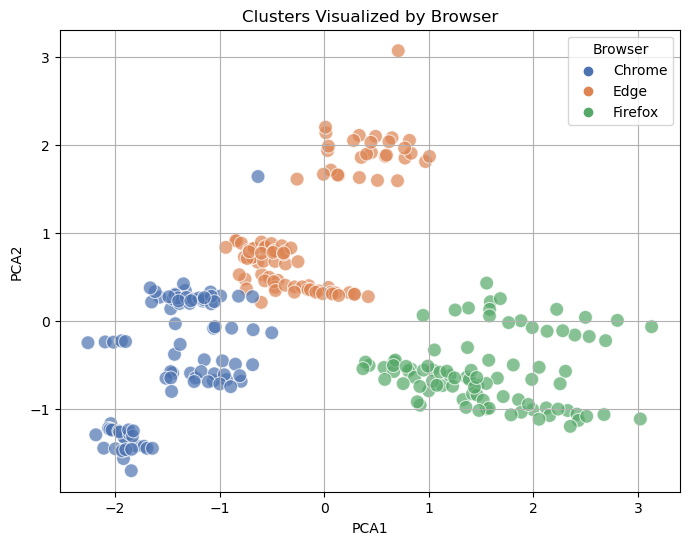

In [7]:
# Based on the printed result we can perfor PCA to further reduce the dimensionality of the data

# Apply PCA to reduce to 2 components and plot the result of the PCA for different browsers to distinguish clusters
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_numerical)

# Convert the PCA result to a DataFrame for easier handling
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_task1 = df_pca.copy()
df_task1['browser'] = data['browser']
df_task1['website'] = data['website']
df_task1['query'] = data['query']



def plot_pca_clusters(df, label_column):
    """
    Plots the clusters of PCA-reduced data colored by the specified label.
    
    Parameters:
    - df: DataFrame containing PCA components and metadata
    - label_column: Column name to be used for coloring the clusters (e.g., 'browser', 'website')
    """
    
    # Set up the matplotlib figure
    plt.figure(figsize=(8, 6))
    
    # Create a scatter plot of the PCA components, colored by the specified label
    sns.scatterplot(
        x='PCA1', y='PCA2',
        hue=label_column,
        palette='deep',
        data=df,
        s=100, alpha=0.7
    )
    
    # Add titles and labels
    plt.title(f'Clusters Visualized by {label_column.capitalize()}')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend(title=label_column.capitalize())
    plt.grid(True)
    #plt.savefig('pca_cluster.png', bbox_inches='tight')
    
    # Show plot
    plt.show()

    
plot_pca_clusters(df_task1, category)

# Unsupervised Clustering Algorithms

1) K-Means and Hierarchial clustering 
2) Coherency analysis with metadata for two clustering Method

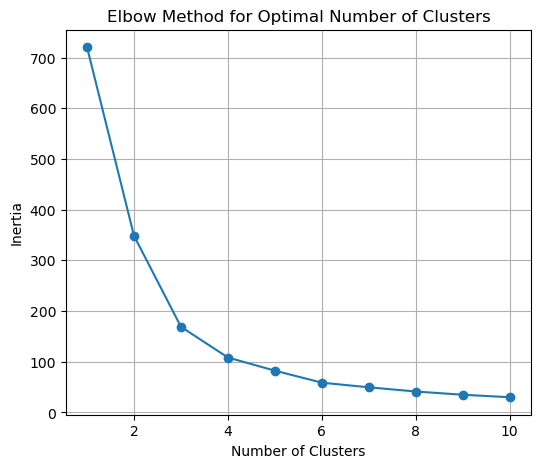

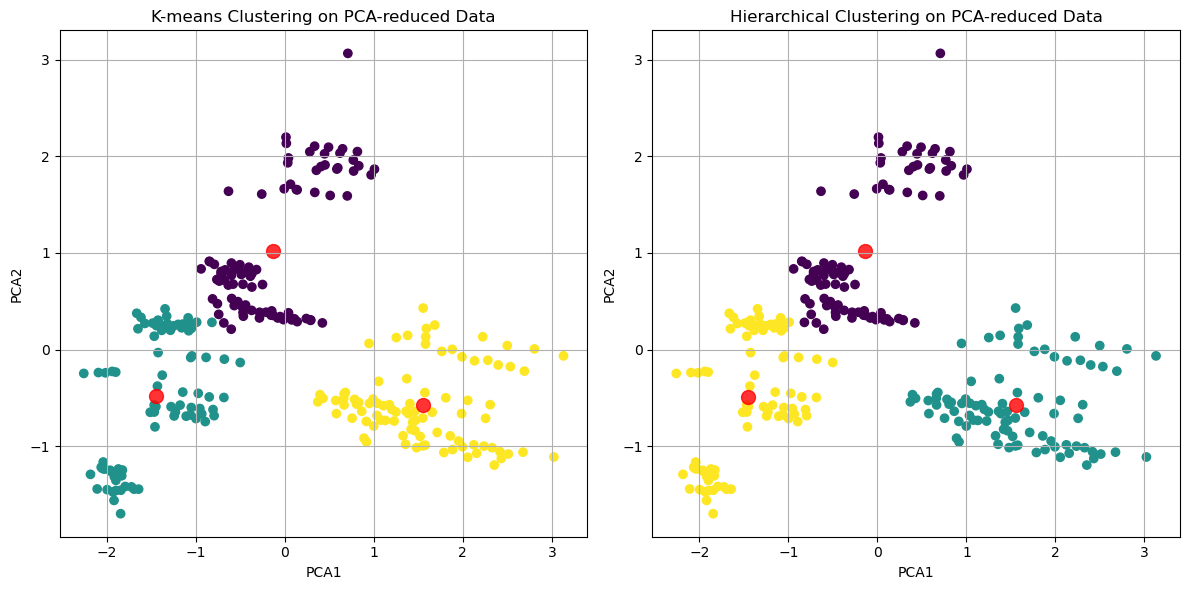

In [8]:
#------------------------------------------------(K-Means and Hierarchial Clustering) -----------------------------------------------#

# we can apply elbow method to determine the best number of clusters:
def plot_elbow_method(pca_df, max_clusters=10, random_state=42):
    """
    Determine the optimal number of clusters using the elbow method and plot the results.
    
    Parameters:
    pca_df (DataFrame): DataFrame containing the PCA-transformed data.
    max_clusters (int): Maximum number of clusters to test. Default is 10.
    random_state (int): Random state for reproducibility. Default is 42.
    
    Returns:
    None
    """
    inertia = []
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(pca_df)
        inertia.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.figure(figsize=(6, 5))
    plt.plot(cluster_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    #plt.savefig('elbow.png', bbox_inches='tight')
    plt.show()
plot_elbow_method(df_pca[['PCA1', 'PCA2']])    

# From domain Knowledge we already know the number of different cluters based on the category we are working on.
"""
if category == 'browser':
    n = 3
elif category == 'website':
    n = 3
elif category == 'query' :
    n = 5
"""

# Also in general we can define the number of clusters with this code
n = len(data[category].unique())

# Apply K-means clustering on the PCA-reduced data
kmeans = KMeans(n_clusters=n, init = 'k-means++' ,random_state=42)
df_pca['KMeans_Cluster'] = kmeans.fit_predict(df_pca[['PCA1', 'PCA2']])
kmeans_centers = kmeans.cluster_centers_

# Plotting the K-means clustering result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['KMeans_Cluster'], cmap='viridis', marker='o')
if kmeans_centers is not None:
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c="red", s=100, alpha=0.8, label="Centers")
plt.title('K-means Clustering on PCA-reduced Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)


# Apply Hierarchical clustering on the PCA-reduced data 
hierarchical = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
df_pca['Hierarchical_Cluster'] = hierarchical.fit_predict(df_pca[['PCA1', 'PCA2']])
# Calculate the centroids of each cluster for Hierarchical Clustering
hierarchical_centers = df_pca.groupby('Hierarchical_Cluster')[['PCA1', 'PCA2']].mean()

# Plotting the Hierarchical clustering result
plt.subplot(1, 2, 2)
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['Hierarchical_Cluster'], cmap='viridis', marker='o')
plt.scatter(hierarchical_centers['PCA1'], hierarchical_centers['PCA2'], c="red", s=100, alpha=0.8, label="Centers")
plt.title('Hierarchical Clustering on PCA-reduced Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)

plt.tight_layout()
#plt.savefig('clustering_result.png', bbox_inches='tight')
plt.show()


In [9]:
#------------------------------------------------Coherency Analysis -----------------------------------------------#
# Add the related metadata to the clustered data
df_pca[category] = data[category]

def assess_clustering_coherence(pca_df, label_category, clustering_method):
    """
    Assess the coherence of clustering results with metadata labels.

    Parameters:
    - pca_df (DataFrame): DataFrame containing PCA-transformed data with clustering results.
    - metadata_label (str): The column name of the metadata label to compare against clusters.
    - clustering_method (str): The clustering method used ('KMeans' or 'Hierarchical').

    Returns:
    - None: Prints the ARI, NMI, and displays the contingency table.
    """

    # Ensure the correct cluster column is selected
    cluster_col = f'{clustering_method}_Cluster'

    # Contingency table between cluster labels and metadata labels
    contingency_table = pd.crosstab(pca_df[cluster_col], pca_df[label_category])
    
    # Plot the contingency table as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Contingency Table: {clustering_method} Clusters vs {label_category}')
    plt.xlabel(label_category)
    plt.ylabel('Cluster')
    #plt.savefig('ct.png', bbox_inches='tight')
    plt.show()

    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(pca_df[label_category], pca_df[cluster_col])
    print(f'Adjusted Rand Index (ARI) for {clustering_method}: {ari:.3f}')

    # Calculate Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(pca_df[label_category], pca_df[cluster_col])
    print(f'Normalized Mutual Information (NMI) for {clustering_method}: {nmi:.3f}')
    
    # Calculate cluster quality: Silhoutte score
    silhouette_avg = silhouette_score(pca_df[['PCA1', 'PCA2']], pca_df[f'{clustering_method}_Cluster'])
    print(f'Silhouette Score: {silhouette_avg}')

    


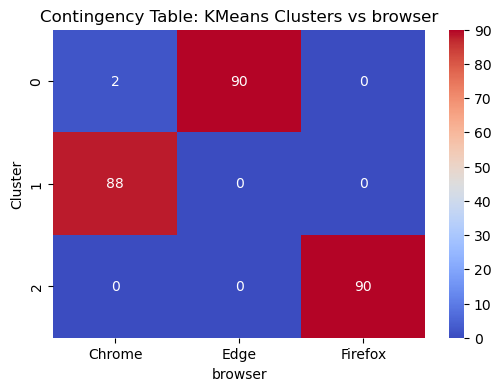

Adjusted Rand Index (ARI) for KMeans: 0.978
Normalized Mutual Information (NMI) for KMeans: 0.968
Silhouette Score: 0.5282744468837659


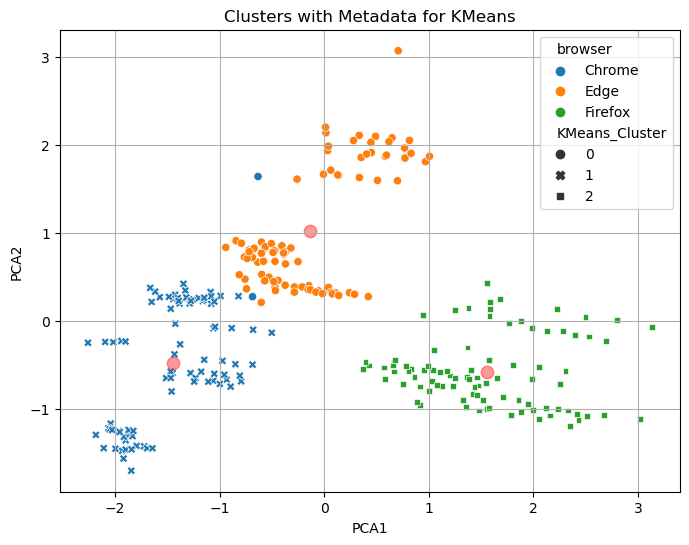

In [10]:
clustering_method = 'KMeans'        
assess_clustering_coherence(df_pca, category, clustering_method)


# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=df_pca)
if kmeans_centers is not None:
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
#plt.savefig('cluster_metadata_kmeans.png', bbox_inches='tight')
plt.show()

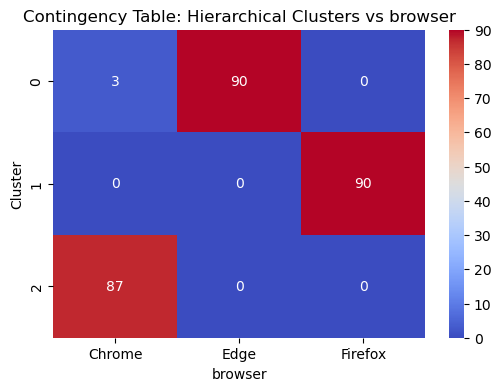

Adjusted Rand Index (ARI) for Hierarchical: 0.967
Normalized Mutual Information (NMI) for Hierarchical: 0.955
Silhouette Score: 0.5284595971383634


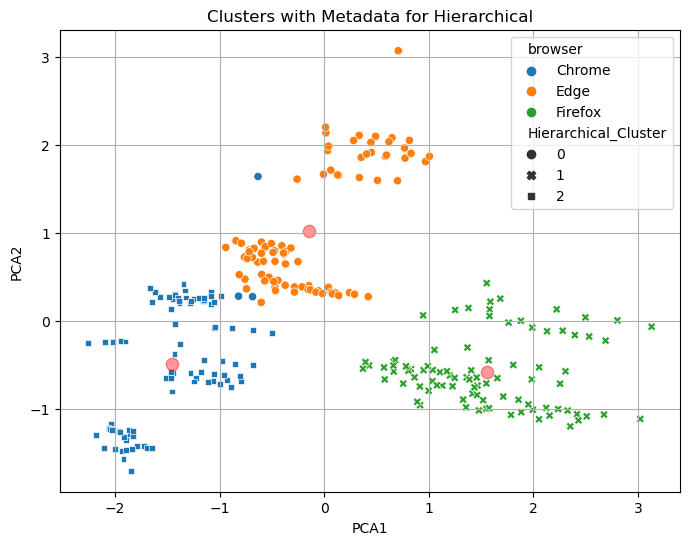

In [11]:
clustering_method = 'Hierarchical'        
assess_clustering_coherence(df_pca, category, clustering_method)

# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=df_pca)
plt.scatter(hierarchical_centers['PCA1'], hierarchical_centers['PCA2'], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
#plt.savefig('cluster_metadata_hierarchical.png', bbox_inches='tight')
plt.show()

In K-Means we have more coherency with the metadata, more over Edge is missclassified in heriarchial clustering looking at the contingency table

# Anomaly Detection

1) Z-Score
2) Isolation Forest
3) DBSCAN

# Z-Score

In [12]:
#------------------------------------------------------------(Z-Score)---------------------------------------------
df_cl = df_pca.copy()
df_cl['Z_Score_Anomaly'] = (np.abs(stats.zscore(df_cl[['PCA1', 'PCA2']])) > 3).any(axis=1)

# Remove the Z-Score anomalies from the dataset
cleaned_data = df_cl[~df_cl['Z_Score_Anomaly']]

# Also in eneral we can define the number of clusters with this code
n = len(cleaned_data[category].unique())


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


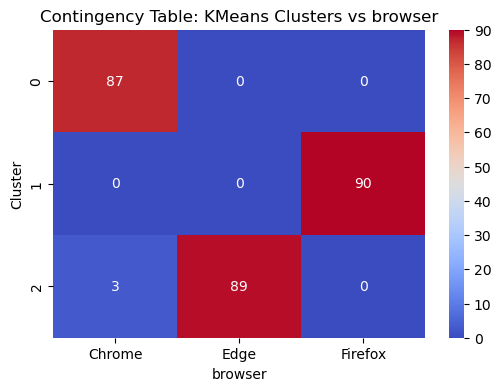

Adjusted Rand Index (ARI) for KMeans: 0.967
Normalized Mutual Information (NMI) for KMeans: 0.955
Silhouette Score: 0.5291862286855137


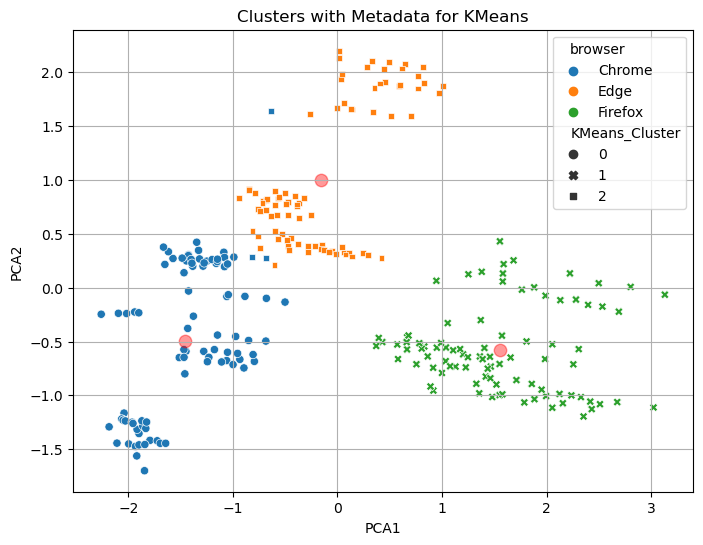

In [13]:
#----------------------------------------------------------K-Means--------------------------------
# Apply K-means clustering on the PCA-reduced data
kmeans = KMeans(n_clusters=n, random_state=42)
cleaned_data['KMeans_Cluster'] = kmeans.fit_predict(cleaned_data[['PCA1', 'PCA2']])
kmeans_centers = kmeans.cluster_centers_

#Clustering Coherence with metadata
clustering_method = 'KMeans'        
assess_clustering_coherence(cleaned_data, category, clustering_method)


# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=cleaned_data)
if kmeans_centers is not None:
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
#plt.savefig('an_cluster_metadata_kmeans.png', bbox_inches='tight')
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


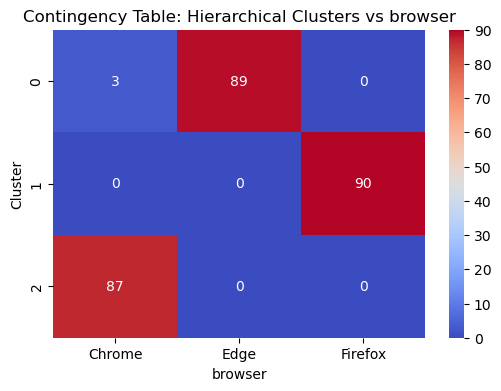

Adjusted Rand Index (ARI) for Hierarchical: 0.967
Normalized Mutual Information (NMI) for Hierarchical: 0.955
Silhouette Score: 0.5291862286855137


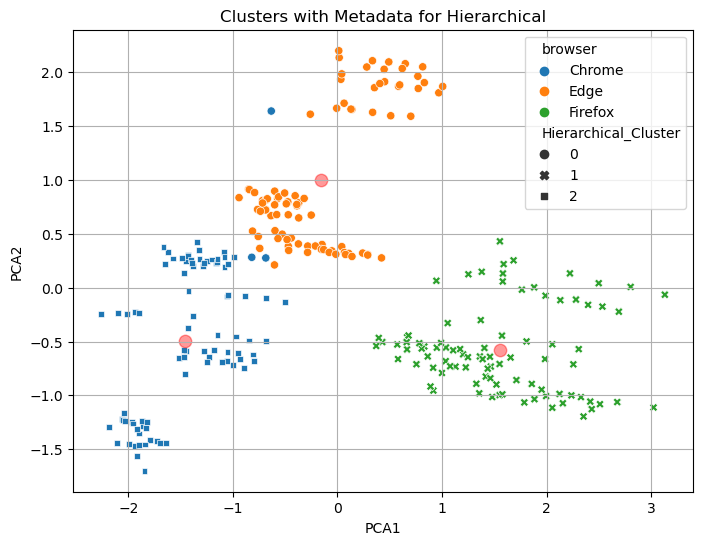

In [14]:
#----------------------------------------------------------Hierarchical-----------------------------------------------

hierarchical = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
cleaned_data['Hierarchical_Cluster'] = hierarchical.fit_predict(cleaned_data[['PCA1', 'PCA2']])
# Calculate the centroids of each cluster for Hierarchical Clustering
hierarchical_centers = cleaned_data.groupby('Hierarchical_Cluster')[['PCA1', 'PCA2']].mean()

#Clustering Coherence with metadata
clustering_method = 'Hierarchical'        
assess_clustering_coherence(cleaned_data, category, clustering_method)

# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=cleaned_data)
plt.scatter(hierarchical_centers['PCA1'], hierarchical_centers['PCA2'], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
plt.show()


In [15]:

# Count the number of anomalies detected 
z_score_anomalies = df_cl['Z_Score_Anomaly'].sum()
print(f'Number of z_score detected anomalies : {z_score_anomalies}')

Number of z_score detected anomalies : 1


# Isolation Forest

In [16]:
#------------------------------------------------------------Isolation forest---------------------------------------------
# Method 2: Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
# Fit the model with named features
iso_forest.fit(df_cl[['PCA1', 'PCA2']])

# Predict anomalies while maintaining the DataFrame structure and passing with feature names
df_cl['IsoForest_Anomaly'] = iso_forest.predict(df_cl[['PCA1', 'PCA2']])

# Convert prediction results to boolean: -1 indicates an anomaly
df_cl['IsoForest_Anomaly'] = df_cl['IsoForest_Anomaly'] == -1

# Remove the Isolation Forest anomalies from the dataset
cleaned_data_iso = df_cl[~df_cl['IsoForest_Anomaly']]


# Also in eneral we can define the number of clusters with this code
n = len(cleaned_data_iso[category].unique())



/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


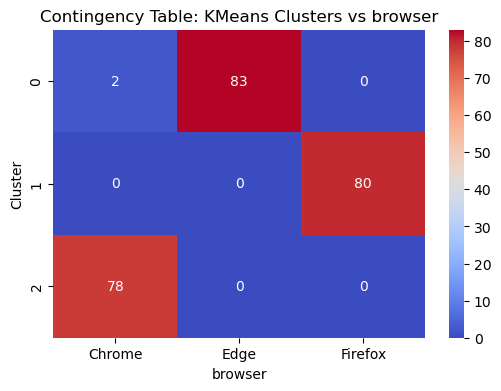

Adjusted Rand Index (ARI) for KMeans: 0.975
Normalized Mutual Information (NMI) for KMeans: 0.965
Silhouette Score: 0.5342385954470006


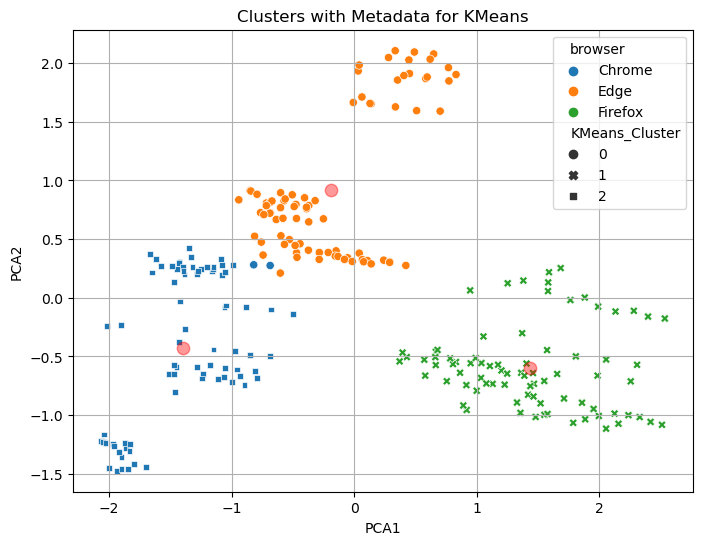

In [17]:
#----------------------------------------------------------K-Means-------------------------------------------------------
# Apply K-means clustering on the PCA-reduced data
kmeans = KMeans(n_clusters=n, random_state=42)
cleaned_data_iso['KMeans_Cluster'] = kmeans.fit_predict(cleaned_data_iso[['PCA1', 'PCA2']])
kmeans_centers = kmeans.cluster_centers_

#Clustering Coherence with metadata
clustering_method = 'KMeans'        
assess_clustering_coherence(cleaned_data_iso, category, clustering_method)


# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=cleaned_data_iso)
if kmeans_centers is not None:
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
#plt.savefig('an_cluster_metadata_kmeans_iso.png', bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


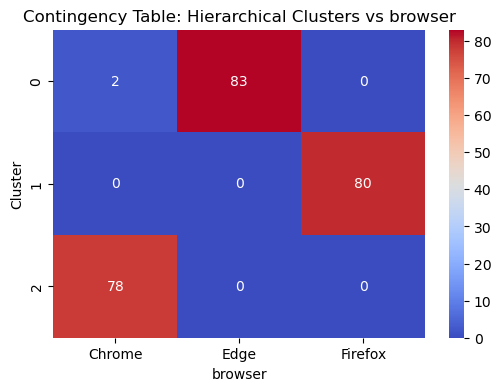

Adjusted Rand Index (ARI) for Hierarchical: 0.975
Normalized Mutual Information (NMI) for Hierarchical: 0.965
Silhouette Score: 0.5342385954470006


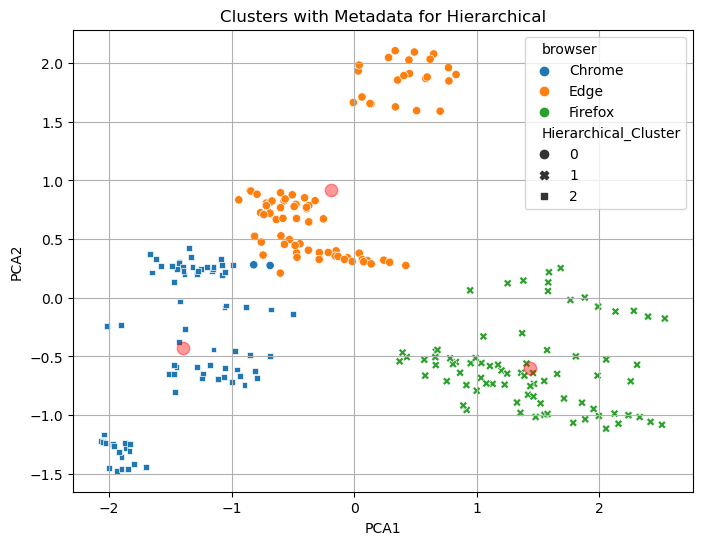

In [18]:
#----------------------------------------------------------Hierarchical--------------------------------------------------

hierarchical = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
cleaned_data_iso['Hierarchical_Cluster'] = hierarchical.fit_predict(cleaned_data_iso[['PCA1', 'PCA2']])
# Calculate the centroids of each cluster for Hierarchical Clustering
hierarchical_centers = cleaned_data_iso.groupby('Hierarchical_Cluster')[['PCA1', 'PCA2']].mean()

#Clustering Coherence with metadata
clustering_method = 'Hierarchical'        
assess_clustering_coherence(cleaned_data_iso, category, clustering_method)

# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=cleaned_data_iso)
plt.scatter(hierarchical_centers['PCA1'], hierarchical_centers['PCA2'], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
plt.show()



In [19]:
# Count the number of anomalies detected by each method
iso_forest_anomalies = df_cl['IsoForest_Anomaly'].sum()
print(f'Number of IsoForest_Anomaly: {iso_forest_anomalies}')

Number of IsoForest_Anomaly: 27


# DBSCAN

In [26]:
#------------------------------------------------------------DBSCAN---------------------------------------------

# Method 3: DBSCAN
#First define the est option for eps parameter based on silhouette_score calculations
pca_data = df_cl[['PCA1', 'PCA2']]
# Define a range of eps values to test
eps_values = np.arange(0.1, 2.0, 0.1)
best_eps = None
best_score = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=4)
    labels = dbscan.fit_predict(pca_data)

    # Ignore noise points (-1) when calculating silhouette score
    if len(set(labels)) > 1:
        score = silhouette_score(pca_data, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f'Best eps: {best_eps}, Best Silhouette Score: {best_score}')

dbscan = DBSCAN(eps= best_eps, min_samples=5)
#dbscan = DBSCAN(eps= 0.2, min_samples=5)

df_cl['DBSCAN_Anomaly'] = dbscan.fit_predict(df_cl[['PCA1', 'PCA2']])
df_cl['DBSCAN_Anomaly'] = df_cl['DBSCAN_Anomaly'] == -1

# Remove the DBSCAN anomalies from the dataset
cleaned_data_dbscan = df_cl[~df_cl['DBSCAN_Anomaly']]


# Also in eneral we can define the number of clusters with this code
n = len(cleaned_data_iso[category].unique())






Best eps: 0.5, Best Silhouette Score: 0.5211437167418974


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


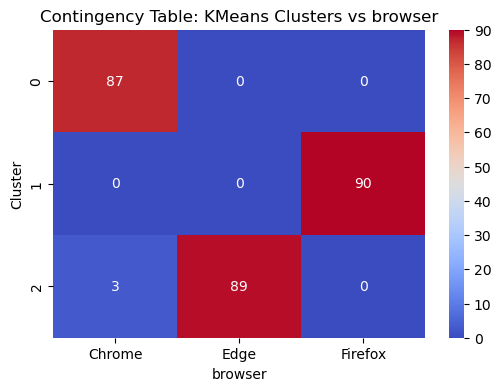

Adjusted Rand Index (ARI) for KMeans: 0.967
Normalized Mutual Information (NMI) for KMeans: 0.955
Silhouette Score: 0.5291862286855137


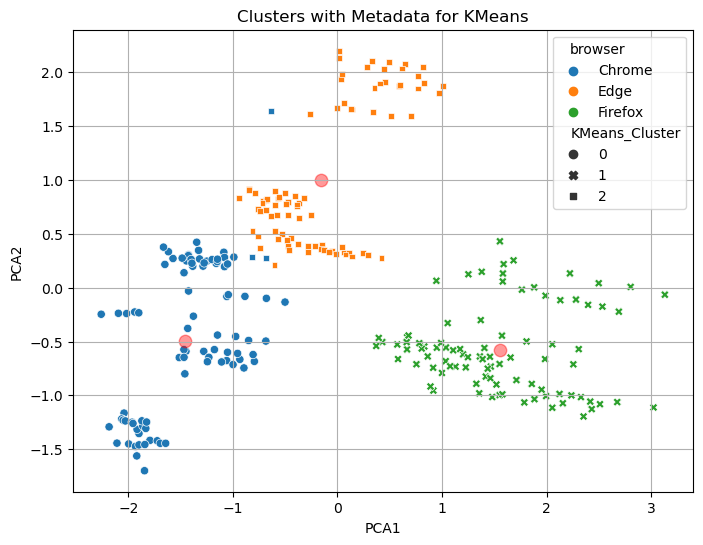

In [27]:
#----------------------------------------------------------K-Means--------------------------------------------------------------------------------

# Apply K-means clustering on the PCA-reduced data
kmeans = KMeans(n_clusters=n, random_state=42)
cleaned_data_dbscan['KMeans_Cluster'] = kmeans.fit_predict(cleaned_data_dbscan[['PCA1', 'PCA2']])
kmeans_centers = kmeans.cluster_centers_

#Clustering Coherence with metadata
clustering_method = 'KMeans'        
assess_clustering_coherence(cleaned_data_dbscan, category, clustering_method)


# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=cleaned_data_dbscan)
if kmeans_centers is not None:
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
#plt.savefig('an_cluster_metadata_kmeans_dbscan.png', bbox_inches='tight')
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


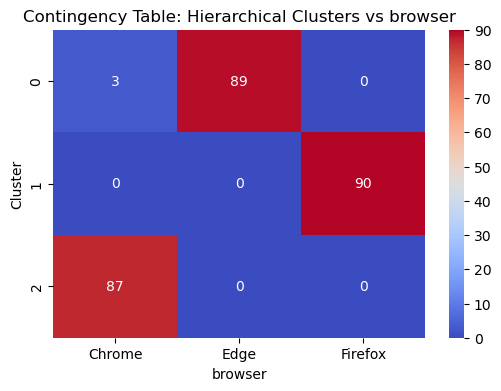

Adjusted Rand Index (ARI) for Hierarchical: 0.967
Normalized Mutual Information (NMI) for Hierarchical: 0.955
Silhouette Score: 0.5291862286855137


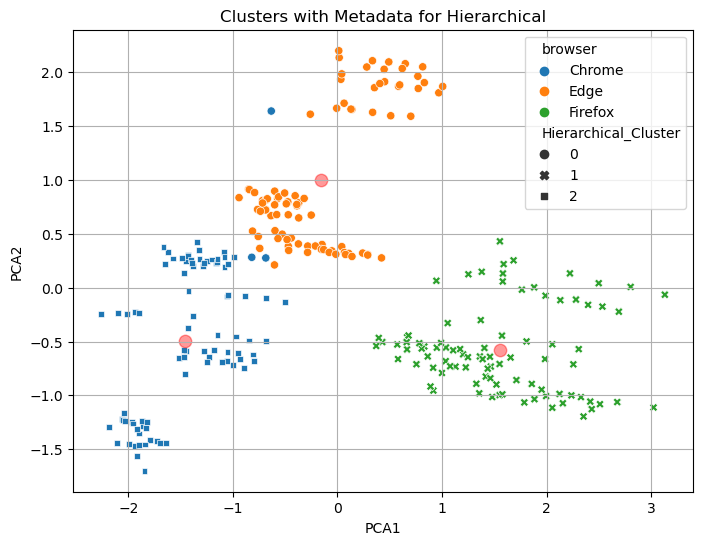

In [29]:
#----------------------------------------------------------Hierarchical--------------------------------------------------------------------------

hierarchical = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
cleaned_data_dbscan['Hierarchical_Cluster'] = hierarchical.fit_predict(cleaned_data_dbscan[['PCA1', 'PCA2']])
# Calculate the centroids of each cluster for Hierarchical Clustering
hierarchical_centers = cleaned_data_dbscan.groupby('Hierarchical_Cluster')[['PCA1', 'PCA2']].mean()

#Clustering Coherence with metadata
clustering_method = 'Hierarchical'        
assess_clustering_coherence(cleaned_data_dbscan, category, clustering_method)

# Plot clusters with metadata color-coded
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=category, style= f'{clustering_method}_Cluster', data=cleaned_data_dbscan)
plt.scatter(hierarchical_centers['PCA1'], hierarchical_centers['PCA2'], c="red", s=80, alpha=0.4, label="Centers")
plt.title(f'Clusters with Metadata for {clustering_method}')
plt.grid(True)
plt.show()

In [30]:
# Count the number of anomalies detected by each method
dbscan_anomalies = df_cl['DBSCAN_Anomaly'].sum()
print(f'Number of dbscan_anomalies: {dbscan_anomalies}')

Number of dbscan_anomalies: 1
